#  Different LSTM NN architecture on Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import islice

from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.preprocessing import sequence
from keras.initializers import he_normal
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import L1L2

Using TensorFlow backend.


In [2]:
#https://stackoverflow.com/questions/54613949/how-to-properly-import-data-from-google-drive-to-google-colab-notebook
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 
#filtered_data = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:18<00:00, 2547.91it/s]


In [24]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

In [25]:
final['preprocessed_reviews'] = preprocessed_reviews
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


In [26]:
data=final[0:50000]
print(data.shape)
data.head(3)
y=data['Score']
x=data['preprocessed_reviews']
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(46071, 11)
(32249,) (32249,)
(13822,) (13822,)


In [27]:
vocabulary=[]
for i in X_train:
  x=i.split()
  vocabulary += x
print(len(vocabulary))

1252639


In [28]:
#https://stackoverflow.com/questions/20510768/count-frequency-of-words-in-a-list-and-sort-by-frequency
from collections import Counter
dic=Counter(vocabulary)
top_words_count=5000
d = dic.most_common(top_words_count)
print(d[4999][0])

bliss


In [29]:
words=[]
frequency=[]
for i in range(len(d)):
  words.append(d[i][0])
  frequency.append(d[i][1])
print(words)
print(frequency)

['not', 'like', 'good', 'great', 'one', 'taste', 'would', 'product', 'coffee', 'flavor', 'tea', 'love', 'food', 'no', 'get', 'really', 'amazon', 'much', 'time', 'use', 'also', 'little', 'best', 'buy', 'tried', 'chocolate', 'price', 'even', 'make', 'find', 'well', 'dog', 'better', 'try', 'eat', 'first', 'could', 'sugar', 'water', 'drink', 'bag', 'cup', 'used', 'found', 'made', 'bought', 'sweet', 'two', 'free', 'way', 'think', 'store', 'since', 'tastes', 'recommend', 'box', 'go', 'delicious', 'day', 'know', 'give', 'mix', 'still', 'order', 'dogs', 'hot', 'bit', 'many', 'favorite', 'treats', 'nice', 'never', 'got', 'want', 'flavors', 'loves', 'every', 'organic', 'brand', 'years', 'makes', 'always', 'without', 'add', 'something', 'right', 'stuff', 'ever', 'quality', 'lot', 'milk', 'less', 'perfect', 'say', 'easy', 'healthy', 'small', 'old', 'ordered', 'salt', 'keep', 'chips', 'different', 'back', 'enough', 'treat', 'fresh', 'eating', 'put', 'ingredients', 'products', 'snack', 'need', 'enjo

In [0]:
#Creating a list to index the words in vocabulary in decreasing order of frequency
a=[x for x in range(1,len(words)+1)]

In [31]:
x=[]
for i in X_train:
    y=i.split()
    x.append(y)
print(x[4985])

['coffee', 'beans', 'not', 'seem', 'fresh', 'no', 'oil', 'ever', 'tasted', 'much', 'better', 'fresher', 'not', 'order']


In [0]:
X_train=[]
xx=[]
for j in range(len(x)):
    for i in x[j]:
      if i in words:
        xx.append(a[words.index(i)])
    X_train.append(xx)
    xx=[]


In [33]:
x=[]
for i in X_test:
    y=i.split()
    x.append(y)
print(x[5001])

['think', 'chips', 'awesome', 'not', 'best', 'along', 'poor', 'brothers', 'salt', 'vinager', 'chips', 'buy', 'spicy', 'thai', 'chips', 'smaller', 'bag', 'might', 'much', 'flavor', 'bottom', 'bag', 'larger', 'bag', 'least', 'experience', 'last', 'time', 'bought', 'amazon', 'like', 'would', 'suggest', 'trying', 'spicy', 'thai', 'bag', 'bigger', 'ounces']


In [34]:
X_test=[]
xx=[]
for j in range(len(x)):
    for i in x[j]:
      if i in words:
        xx.append(a[words.index(i)])
    X_test.append(xx)
    xx=[]
print(X_test)

[[161, 3520, 4, 27, 8, 623, 332, 337, 573, 3, 795, 19, 1426, 25, 194, 23, 861], [12, 361, 426, 86, 1937, 1636, 153, 1937, 1636, 22, 1684, 464, 411, 84, 66, 1047, 22, 185, 141, 84, 714, 1187, 430, 423, 1622, 22, 100, 426, 35, 1392, 2, 1887, 1976, 260, 3, 177, 13], [67, 2208, 2, 50, 173, 1, 2, 135, 85, 1, 229, 1, 86, 208, 622, 3302, 523, 317, 99, 8, 4753, 1442, 3443, 297, 223, 15, 21, 2, 642, 4880], [406, 215, 522, 483, 65, 65, 271, 776, 1748, 1, 2132, 1246, 2981], [312, 27, 1, 8, 3310, 1266, 224, 5, 19, 559, 24, 309, 131, 763, 162, 132, 1459, 41, 19, 633, 279, 302, 1459, 3554, 24, 716, 81, 4, 42, 1453, 31, 730, 1215], [4, 57, 112, 154, 1332, 172, 98, 14, 1572, 861, 2, 459, 555, 1332, 18, 3285, 21, 4, 343, 4193, 112, 2262, 2873, 260, 839], [5, 23, 1802, 617, 21, 2938, 17, 113, 33, 27, 2560, 258, 1375, 82, 15, 1934, 2377, 258, 3964, 241, 268, 161, 224, 184, 10, 1, 261, 51, 69], [127, 1, 302, 413, 568, 293, 23, 1, 1128, 1, 3, 9, 452, 146, 742, 179, 642, 1, 120, 7, 2169], [32, 34, 106, 257,

## padding to maxe equal length lists for all points in data  

In [35]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[0])

(32249, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

#2 Layer LSTM Neural Network

In [36]:
# create the model
# Bias regularizer value - we will use elasticnet
#https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/
reg = L1L2(0.01, 0.01)
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(a)+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(60,return_sequences=True,bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(LSTM(40))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 60)           22320     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 60)           240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                16160     
_____________________________________

In [37]:
history =model.fit(X_train, y_train, nb_epoch=10, batch_size=256,validation_data=(X_test, y_test))
# Final evaluation of the model
scores2 = model.evaluate(X_test, y_test, verbose=0)
print("Test score: %.2f%%" % (scores2[0]))
print("Accuracy: %.2f%%" % (scores2[1]*100))




Train on 32249 samples, validate on 13822 samples
Epoch 1/10





32249/32249 [==============================] - 310s 10ms/step - loss: 1.4175 - acc: 0.8704 - val_loss: 1.3994 - val_acc: 0.8738
Epoch 2/10
32249/32249 [==============================] - 304s 9ms/step - loss: 1.0743 - acc: 0.9281 - val_loss: 1.0148 - val_acc: 0.9110
Epoch 3/10
32249/32249 [==============================] - 304s 9ms/step - loss: 0.8635 - acc: 0.9459 - val_loss: 0.8800 - val_acc: 0.9168
Epoch 4/10
32249/32249 [==============================] - 305s 9ms/step - loss: 0.6857 - acc: 0.9562 - val_loss: 0.7323 - val_acc: 0.9133
Epoch 5/10
32249/32249 [==============================] - 304s 9ms/step - loss: 0.5355 - acc: 0.9644 - val_loss: 0.6398 - val_acc: 0.9106
Epoch 6/10
32249/32249 [==============================] - 305s 9ms/step - loss: 0.4053 - acc: 0.9725 - val_loss: 0.5959 - val_acc: 0.9029
Epoch 7/10
32249/32249 [==============================] - 305s 9ms/step - loss: 0.2977 - acc: 0.9779 - val_loss: 

Text(0, 0.5, 'loss')

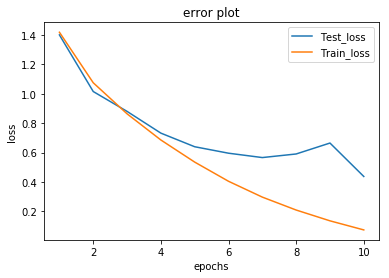

In [38]:
# list of epoch numbers
nb_epoch=10
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
test_los,=plt.plot(x,vy,label="Test_loss")
train_los,=plt.plot(x,ty,label="Train_loss")
plt.legend(handles=[test_los,train_los])
plt.title("error plot")
plt.xlabel("epochs")
plt.ylabel("loss")

#3 Layer LSTM Neural Network

In [39]:
# create the model
embedding_vecor_length = 32
model3 = Sequential()
model3.add(Embedding(len(a)+1, embedding_vecor_length, input_length=max_review_length))
model3.add(LSTM(100,return_sequences=True,bias_regularizer=reg))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(LSTM(80,return_sequences=True,bias_regularizer=reg))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(LSTM(60))


model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 600, 100)          400       
_________________________________________________________________
dropout_3 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 600, 80)           57920     
_________________________________________________________________
batch_normalization_3 (Batch (None, 600, 80)           320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 600, 80)          

In [40]:
history =model3.fit(X_train, y_train, nb_epoch=10, batch_size=128,validation_data=(X_test,y_test))
# Final evaluation of the model
scores5 = model3.evaluate(X_test, y_test, verbose=0)
print("Test score: %.2f%%" % (scores5[0]))
print("Accuracy: %.2f%%" % (scores5[1]*100))

Train on 32249 samples, validate on 13822 samples
Epoch 1/10
32249/32249 [==============================] - 904s 28ms/step - loss: 3.2573 - acc: 0.8852 - val_loss: 2.6979 - val_acc: 0.8850
Epoch 2/10
32249/32249 [==============================] - 906s 28ms/step - loss: 2.1033 - acc: 0.9287 - val_loss: 1.7007 - val_acc: 0.9127
Epoch 3/10
32249/32249 [==============================] - 920s 29ms/step - loss: 1.2852 - acc: 0.9429 - val_loss: 1.0663 - val_acc: 0.8961
Epoch 4/10
32249/32249 [==============================] - 915s 28ms/step - loss: 0.6918 - acc: 0.9512 - val_loss: 0.8202 - val_acc: 0.8714
Epoch 5/10
32249/32249 [==============================] - 897s 28ms/step - loss: 0.2698 - acc: 0.9619 - val_loss: 0.2686 - val_acc: 0.9100
Epoch 6/10
32249/32249 [==============================] - 882s 27ms/step - loss: 0.0934 - acc: 0.9682 - val_loss: 0.2845 - val_acc: 0.9046
Epoch 7/10
32249/32249 [==============================] - 899s 28ms/step - loss: 0.0765 - acc: 0.9745 - val_loss: 0.

Text(0, 0.5, 'loss')

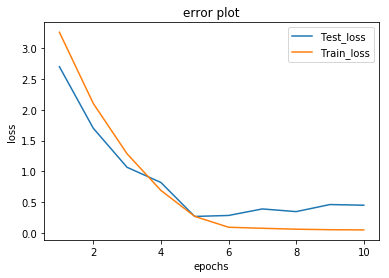

In [41]:
# list of epoch numbers
nb_epoch=10
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
test_los,=plt.plot(x,vy,label="Test_loss")
train_los,=plt.plot(x,ty,label="Train_loss")
plt.legend(handles=[test_los,train_los])
plt.title("error plot")
plt.xlabel("epochs")
plt.ylabel("loss")  

# [6] Conclusions

In [42]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["LSTM","Test_score","Test_accuracy"]
x.add_row(["2 LAYER",scores2[0],scores2[1]])
x.add_row(["3 LAYER",scores5[0],scores5[1]])
print(x)

+---------+---------------------+--------------------+
|   LSTM  |      Test_score     |   Test_accuracy    |
+---------+---------------------+--------------------+
| 2 LAYER | 0.43786143052165716 | 0.9070322673394252 |
| 3 LAYER | 0.45072186808758785 | 0.8963970481236821 |
+---------+---------------------+--------------------+


# steps followed in presenting data

1.Amazon fine food reviews data set is loaded and divide in to train and test 
data sets.
<br>
2.all the words in test and train set  are replaced by numbers by indexing them in decreasing order of their frequency 
<br>
2.2 different lstm architectures with batch drop out layes along with relu activation units and adam optimizer are applied on MNIST data to identy the digits.
<br>
3.since it is a multi classification problem softmax activation is used at the output layer.
<br>
4.Error plots are plotted for both tain and test loss.
<br>
5.Results obtained are represented using pretty table.